In [1]:
%load_ext autoreload
%autoreload 2

from ble import get_ble_controller
from base_ble import LOG
from cmd_types import CMD
import time
import numpy as np
import matplotlib.pyplot as plt

LOG.propagate = False

In [2]:
# Get ArtemisBLEController object
ble = get_ble_controller()

# Connect to the Artemis Device
ble.connect()

2023-04-11 15:37:55,751 | INFO     |: Looking for Artemis Nano Peripheral Device: C0:83:b1:6a:38:3C
2023-04-11 15:37:58,719 | INFO     |: Connected to C0:83:b1:6a:38:3C


D:\Workspace\ECE-5160-Sp23\ble_robot-1.1\ble_python\base_ble.py:87: FutureWarning: This method will be removed future version, pass the callback to the BleakClient constructor instead.
  self.client.set_disconnected_callback(self.disconnect_handler)


In [3]:
def get_data_cb(uuid, byte_array):
    global tof_list, pwm_list
    if byte_array is not None:
        s = byte_array.decode("utf-8")
        s = s.split("|")  # split each reading
        
        if s[0] == 'T':
            # TOF
            readings = s[1].split(',')[:-1]
            for data in readings:
                data = data.split('&')
                time = int(data[0])
                tof  = int(data[1])
                if tof > 0:
                    tof_time_list.append(time)
                    tof_data_list.append(tof)
        
        elif s[0] == 'P':
            # PWM
            readings = s[1].split(',')[:-1]
            for data in readings:
                data = data.split('&')
                time = int(data[0])
                pwm  = int(data[1])
                if pwm > 0:
                    pwm_time_list.append(time)
                    pwm_data_list.append(pwm)
        
        elif s[0] == 'K':
            # PWM
            readings = s[1].split(',')[:-1]
            for data in readings:
                data = data.split('&')
                time = int(data[0])
                kf  = int(data[1])
                if kf > 0:
                    kf_time_list.append(time)
                    kf_data_list.append(kf)

In [4]:
ble.start_notify(ble.uuid['RX_STRING'], get_data_cb)

In [5]:
tof_data_list = []
pwm_data_list = []
tof_time_list = []
pwm_time_list = []
kf_data_list = []
kf_time_list = []


In [6]:
# start
ble.send_command(CMD.SEND_TWO_INTS, "")

In [7]:
# stop
ble.send_command(CMD.SEND_THREE_FLOATS, "")

In [8]:
ble.stop_notify(ble.uuid['RX_STRING'])

In [9]:
tof_time_list = [x - tof_time_list[0] for x in tof_time_list]
pwm_time_list = [x - pwm_time_list[0] for x in pwm_time_list]
kf_time_list  = [x - kf_time_list[0]  for x in kf_time_list ]

if tof_time_list[-1] > 1000:
    tof_time_list = np.array(tof_time_list)/1000
    pwm_time_list = np.array(pwm_time_list)/1000

In [10]:
print(tof_data_list)
print(tof_time_list)
print(pwm_data_list)
print(pwm_time_list)
print(kf_data_list)
print(kf_time_list)

[2286, 2552, 2183, 1974, 2002, 1870, 1877, 2101, 2187, 2202, 2019, 2046, 2033, 2173, 2694, 1851, 1905, 2398, 2009, 1797, 1950, 2000, 2093, 2288, 1859, 2134, 354]
[0.    0.06  0.124 0.189 0.298 0.348 0.416 0.523 0.616 0.723 0.776 0.843
 0.905 0.965 1.074 1.124 1.226 1.28  1.351 1.418 1.525 1.618 1.685 1.755
 1.818 1.928 2.023]
[95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95]
[0.    0.066 0.131 0.197 0.306 0.355 0.421 0.53  0.624 0.734 0.787 0.847
 0.908 0.972 1.076 1.125 1.235 1.289 1.362 1.422 1.525 1.629 1.695 1.761
 1.827 1.931]
[2175, 2240, 2267, 2278, 2437, 2504, 2533, 2545, 2550, 2340, 2251, 2213, 2197, 2070, 2016, 1994]
[0, 17, 28, 40, 66, 74, 83, 97, 109, 127, 139, 152, 163, 193, 204, 215]


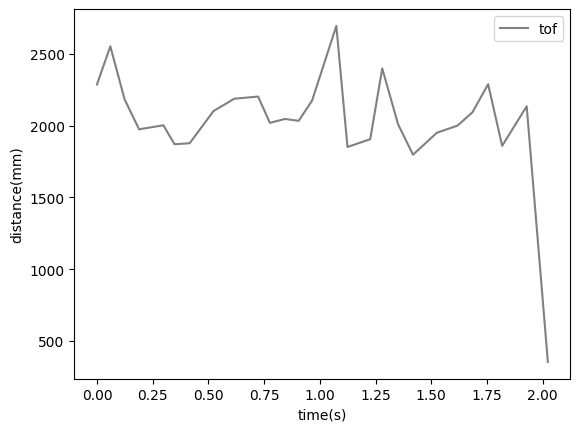

In [11]:
plt.plot(tof_time_list, tof_data_list, color='gray', label='tof')
plt.legend(loc="upper right")
plt.xlabel('time(s)')
plt.ylabel('distance(mm)')
plt.show()

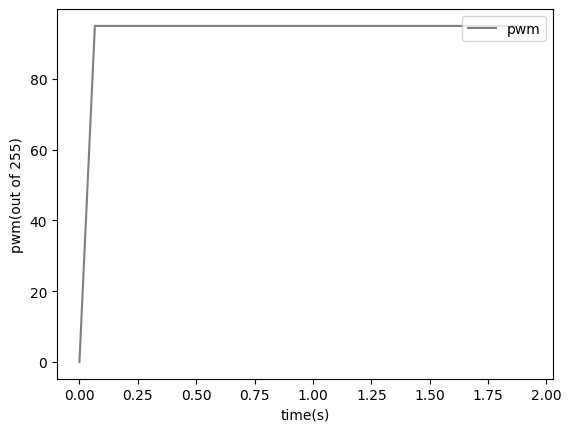

In [12]:
if pwm_data_list[0] != 0:
    pwm_data_list[0] = 0

plt.plot(pwm_time_list, pwm_data_list, color='gray', label='pwm')
plt.legend(loc="upper right")
plt.xlabel('time(s)')
plt.ylabel('pwm(out of 255)')
plt.show()

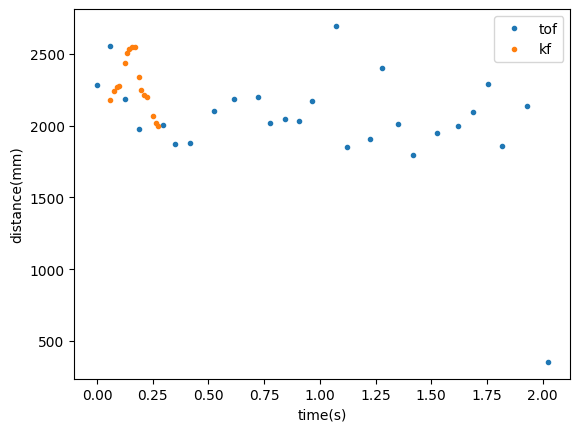

In [13]:
plt.plot(tof_time_list, tof_data_list, '.', label='tof')
plt.plot((np.array(kf_time_list)+60)/1000, kf_data_list, '.', label='kf')
plt.legend(loc="upper right")
plt.xlabel('time(s)')
plt.ylabel('distance(mm)')
plt.show()

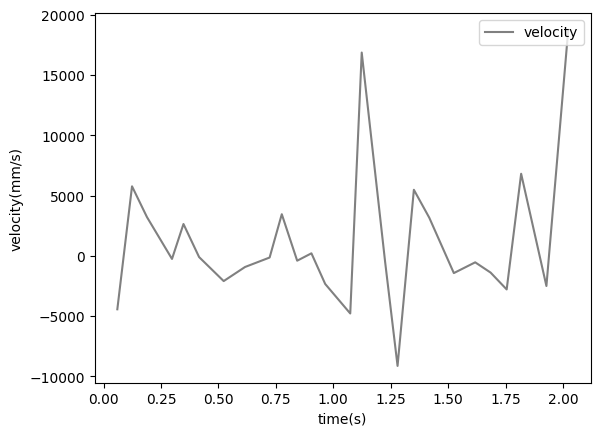

In [14]:
velocity_list = -1 * np.diff(tof_data_list)/np.diff(tof_time_list)
plt.plot(tof_time_list[1:], velocity_list, color='gray', label='velocity')
plt.legend(loc="upper right")
plt.xlabel('time(s)')
plt.ylabel('velocity(mm/s)')
plt.show()

In [15]:
max_vel = max(velocity_list)
rise_val = max_vel * 0.9
rise_time = tof_time_list[ np.where(velocity_list > rise_val)[0][0] + 1]
drag = 1/max_vel

print("90% rise time =", rise_time, "s")
print("Max velocity = {v:.2f}".format(v=max_vel), "mm/s")
print("Drag = {d:.6f}".format(d=drag))

90% rise time = 2.023 s
Max velocity = 18736.84 mm/s
Drag = 0.000053
